In [2]:
source_dir = '/content/dataset/'
destination_dir = '/content/dataset-split/'
training_data_dir = '/content/dataset-split/train'
test_data_dir = '/content/dataset-split/test'
valid_data_dir = '/content/dataset-split/valid'
image_size = (32, 32)

In [4]:
import os
from enum import Enum
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import cv2
import random
from PIL import Image
import shutil
import random
import pickle
import pandas as pd

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, Lion
from keras.regularizers import L2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, RandomRotation, RandomContrast, RandomBrightness, RandomFlip,RandomZoom
from efficientnet.tfkeras import EfficientNetB0
from keras_cv.layers import RandomCutout
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend


Handling randomness

In [6]:
seeds = [123,42,9]

In [7]:
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)


Data preprocessing

In [ ]:
# Define the split percentages
train_percent = 0.7
test_percent = 0.2
valid_percent = 0.1

# Create destination directories
train_dir = os.path.join(destination_dir, 'train')
test_dir = os.path.join(destination_dir, 'test')
valid_dir = os.path.join(destination_dir, 'valid')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(destination_dir, exist_ok=True)

# Iterate over ttv (train, test, valid) folder
for ttv_folder in os.listdir(source_dir):
    ttv_path = os.path.join(source_dir, ttv_folder)
    if os.path.isdir(ttv_path):
        for class_folder in os.listdir(ttv_path):
            class_path = os.path.join(ttv_path, class_folder)
            if os.path.isdir(class_path):
                # Collect image files, ignoring .DS_Store files
                images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and not f.startswith('.DS_Store')]
                # Shuffle images
                random.shuffle(images)

                # Calculate split sizes
                num_images = len(images)
                num_train = int(num_images * train_percent)
                num_test = int(num_images * test_percent)
                num_valid = num_images - num_train - num_test

                # Split images
                train_images = images[:num_train]
                test_images = images[num_train:num_train + num_test]
                valid_images = images[num_train + num_test:]

                # Move images to respective directories preserving class folder structure
                for img in train_images:
                    src = os.path.join(class_path, img)
                    dst = os.path.join(destination_dir, "train", class_folder, img)
                    os.makedirs(os.path.dirname(dst), exist_ok=True)
                    shutil.copy(src, dst)

                for img in test_images:
                    src = os.path.join(class_path, img)
                    dst = os.path.join(destination_dir, "test", class_folder, img)
                    os.makedirs(os.path.dirname(dst), exist_ok=True)
                    shutil.copy(src, dst)

                for img in valid_images:
                    src = os.path.join(class_path, img)
                    dst = os.path.join(destination_dir, "valid", class_folder, img)
                    os.makedirs(os.path.dirname(dst), exist_ok=True)
                    shutil.copy(src, dst)

In [8]:
def load_data_from_directory(directory, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_names = [class_name for class_name in class_names if class_name != '.DS_Store']
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_file in os.listdir(class_dir):
            if img_file == '.DS_Store':
                continue  # Skip .DS_Store files
            img_path = os.path.join(class_dir, img_file)
            try:
                img = Image.open(img_path).convert('RGB')  # Ensure images are in RGB format
                img = img.resize(target_size)
                img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(class_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    # Convert labels to one-hot encoded vectors
    label_map = {label: i for i, label in enumerate(class_names)}
    labels = [label_map[label] for label in labels]
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

    return np.array(images), np.array(labels)


In [9]:


# Load data from directories
pre_train_images, pre_train_labels = load_data_from_directory(training_data_dir, image_size)
pre_valid_images, pre_valid_labels = load_data_from_directory(valid_data_dir, image_size)
pre_test_images, pre_test_labels = load_data_from_directory(test_data_dir, image_size)


In [10]:
# Combine images and labels into a single array
train_data = list(zip(pre_train_images, pre_train_labels))
valid_data = list(zip(pre_valid_images, pre_valid_labels))
test_data = list(zip(pre_test_images, pre_test_labels))

# Shuffle the data
np.random.shuffle(train_data)
np.random.shuffle(valid_data)
np.random.shuffle(test_data)

# Unzip the shuffled data
train_images, train_labels = zip(*train_data)
valid_images, valid_labels = zip(*valid_data)
test_images, test_labels = zip(*test_data)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

## Pipeline

Classes

In [11]:
class AugmentationTechnique(Enum):
    NoAugmentation = 0
    Rotation = 1
    Flipping = 2
    Contrast = 3
    Zoom = 4
    Brightness = 5
    RandomErasing = 6

class ModelType(Enum):
    MobileNet =1
    EfficientNet = 2

class OptimizerType(Enum):
    Adam = 1
    Sgd=2
    Lion=3
class RegularizationType(Enum):
    NoRegularization = 1
    L2 =2
    Dropout=3
def getRegularizer(regularizerType,value):
    match regularizerType:
        case RegularizationType.L2:
            return L2(value)
def getDenseLayer(model,regularization, activation,nodes):
        match regularization['type']:
            case RegularizationType.Dropout:
                model.add(Dropout(rate=regularization['value']))
                model.add(Dense(nodes, activation=activation))
            case RegularizationType.NoRegularization:
                model.add(Dense(nodes, activation=activation))
            case RegularizationType.L2:
                model.add(Dense(nodes, activation=activation, kernel_regularizer=getRegularizer(regularizerType=regularization['type'],value=regularization['value'])))
def getAugmentationLayer(model,technique, seed):
    match technique:
        case AugmentationTechnique.NoAugmentation:
            return;
        case AugmentationTechnique.Rotation:
            model.add(RandomRotation(factor=(-0.2, 0.3),seed=seed))
        case AugmentationTechnique.Flipping:
            model.add(RandomFlip(mode="horizontal_and_vertical", seed=seed))
        case AugmentationTechnique.Brightness:
            model.add(RandomBrightness(factor=(-0.4,0.4),seed=seed))
        case AugmentationTechnique.Contrast:
            model.add(RandomContrast(factor=0.4,seed=seed))
        case AugmentationTechnique.RandomErasing:
            model.add(RandomCutout(height_factor=0.5,width_factor=0.5,seed=seed))
        case AugmentationTechnique.Zoom:
            model.add(RandomZoom(.5, .2,seed=seed))


class Model:
    def fit(self,batch_size,epochs,train_images,train_labels,valid_images,valid_labels):
        pass
    def predict(self,test_images):
        pass
    def __init__(self,optimizer,loss,metrics):
        pass

class CustomMobileNetModel(Model):
    def __init__(self,optimizer,loss,metrics,regularizer,seed,augmentation):
        # Load MobileNetV3Large without the top classification layer
        base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

        # Freeze the base model layers
        base_model.trainable = False

        # Add additional layers on top of MobileNetV3Large
        model = tf.keras.Sequential()
        getAugmentationLayer(model,technique=augmentation,seed=seed)
        model.add(base_model)
        model.add(GlobalAveragePooling2D())

        getDenseLayer(model=model,regularization=regularizer,activation='relu',nodes=1024)
        model.add(BatchNormalization())
        getDenseLayer(model=model,regularization=regularizer,activation='relu',nodes=512)
        model.add(BatchNormalization())
        getDenseLayer(model=model,regularization=regularizer,activation='softmax',nodes=10)
            # Output layer with size 10 for classification
        model.build(input_shape=(None, 32, 32, 3))
        for layer in model.layers[1:]:
            layer.trainable = True
        # Compile the model
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model=model

    def fit(self,batch_size,epochs,train_images,train_labels,valid_images,valid_labels):
        return self.model.fit(
        train_images,
        train_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(valid_images,valid_labels)
        )
    def predict(self,test_images):
        return self.model.predict(test_images)

class CustomEfficientNetModel(Model):
    def __init__(self,optimizer,loss,metrics, regularizer,seed,augmentation):
        # Load MobileNetV3Large without the top classification layer
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

        # Freeze the base model layers
        base_model.trainable = False
        # Add additional layers on top of EfficientNet
        model = tf.keras.Sequential()
        getAugmentationLayer(model,technique=augmentation,seed=seed)
        model.add(base_model)
        model.add(GlobalAveragePooling2D())
        getDenseLayer(model=model,regularization=regularizer,activation='relu',nodes=1024)
        model.add(BatchNormalization())
        getDenseLayer(model=model,regularization=regularizer,activation='relu',nodes=512)
        model.add(BatchNormalization())
        getDenseLayer(model=model,regularization=regularizer,activation='softmax',nodes=10)
            # Output layer with size 10 for classification
        model.build(input_shape=(None, 32, 32, 3))
        # Compile the model
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model=model
    def fit(self,batch_size,epochs,train_images,train_labels,valid_images,valid_labels):
        return self.model.fit(
        train_images,
        train_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(valid_images,valid_labels)
        )
    def predict(self,test_images):
        return self.model.predict(test_images)


Helper functions

In [12]:

def createModel(modelType, optimizer, loss, metrics, regularizer,seed,augmentation)->Model:
    match modelType:
        case ModelType.MobileNet:
            return CustomMobileNetModel(optimizer=optimizer,loss=loss,metrics=metrics,regularizer=regularizer,seed=seed,augmentation=augmentation)
        case ModelType.EfficientNet:
            return CustomEfficientNetModel(optimizer=optimizer,loss=loss,metrics=metrics,regularizer=regularizer,seed=seed,augmentation=augmentation)

def getAccuracy(y_result, y_test):
    correct_amount =0
    for i, result in enumerate(y_result):
        if result == y_test[i]:
            correct_amount+=1
    return correct_amount/len(y_test)

def getOptimizer(type, learningRate):
    match type:
        case OptimizerType.Adam:
            return Adam(learning_rate=learningRate)
        case OptimizerType.Sgd:
            return SGD(learning_rate=learningRate)
        case OptimizerType.Lion:
            return Lion(learning_rate=learningRate)



# Arrays containing different hyper-parameter values

Main pipeline loop

In [13]:
def performSingleExperiment(modelType, batchSize, epochNumber, augmentation, regularizer, learningRate, seed, optimizerType):
    print(f"Performing experiment with model: {modelType}, batch size: {batchSize}, epochs: {epochNumber}, augmentation: {augmentation}, regularizer: {regularizer}, learning rate: {learningRate}, seed: {seed}")

    set_seed(seed)

    model = createModel(modelType=modelType,regularizer=regularizer,optimizer=getOptimizer(type=optimizerType,learningRate=learningRate), loss='categorical_crossentropy', metrics=['accuracy'],seed=seed, augmentation=augmentation)
    # train the model
    history = model.fit(batch_size=batchSize,epochs=epochNumber, train_images=train_images[:int(len(train_images)/20)],train_labels=train_labels[:int(len(train_labels)/20)],valid_images=valid_images[:int(len(valid_images)/20)],valid_labels=valid_labels[:int(len(valid_labels)/20)])

    # get accuracy
    y_pred = model.predict(test_images)
    # Convert probabilities to class labels
    predicted_classes = np.argmax(y_pred, axis=1)

    # Get true class labels
    true_classes = np.argmax(test_labels, axis=1)
    accuracy = getAccuracy(predicted_classes,true_classes)
    return [accuracy, augmentation,regularizer,batchSize,learningRate,epochNumber, seed], history


def performExperiment(batchSizes, learningRates, numberOfEpochs, augmentationTechniques, regularizers,modelType,seeds,optimizerType):
    results = []
    histories = []
    accuracy=0
    accuracyMean = 0
    accuracyArray=[]

    currentBestBatchSize = batchSizes[0]
    currentBestLearningRate = learningRates[0]
    currentBestNumberOfEpochs = 10
    lastExperimentNumberOfEpochs = 50
    currentBestAugmentation =augmentationTechniques[0]
    currentBestRegularizer = regularizers[0]

    for seed in seeds:
        result,history=performSingleExperiment(modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,regularizer=currentBestRegularizer,seed=seed,optimizerType=optimizerType)
        results.append(result)
        accuracyArray.append(result[0])
    accuracyMean=np.mean(accuracyArray)
    accuracyArray=[]


    for augmentation in augmentationTechniques[1:]:
        for seed in seeds:
            result,history=performSingleExperiment(modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=augmentation,regularizer=currentBestRegularizer,seed=seed,optimizerType=optimizerType)
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestAugmentation=augmentation
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]


    for regularizer in regularizers[1:]:
        for seed in seeds:
            result,history=performSingleExperiment(modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,regularizer=regularizer,seed=seed,optimizerType=optimizerType)
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestRegularizer=regularizer
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]


    for batchSize in batchSizes[1:]:
        for seed in seeds:
            result,history=performSingleExperiment(modelType=modelType,learningRate=currentBestLearningRate,batchSize=batchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,regularizer=currentBestRegularizer,seed=seed,optimizerType=optimizerType)
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestBatchSize=batchSize
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]

    for learningRate in learningRates[1:]:
        for seed in seeds:
            result,history=performSingleExperiment(modelType=modelType,learningRate=learningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,regularizer=currentBestRegularizer,seed=seed,optimizerType=optimizerType)
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestLearningRate=learningRate
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]


    result,history=performSingleExperiment(modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=lastExperimentNumberOfEpochs,augmentation=currentBestAugmentation,regularizer=currentBestRegularizer,seed=seed,optimizerType=optimizerType)
    accuracy = result[0]
    results.append(result)
    histories.append(history)



    return results, [accuracy,currentBestBatchSize, currentBestLearningRate,currentBestNumberOfEpochs, currentBestAugmentation,currentBestRegularizer], histories

# Arrays containing different hyper-parameter values

In [14]:

# training process
batchSizes =[128,64,32]
#batchSizes = [512]
learningRates = [0.01,0.005,0.001]
#learningRates=[0.1]
#numberOfEpochs =[5,10,15]
numberOfEpochs=[10]

# regularization
#regularizers = [{"type":RegularizationType.NoRegularization,"value":0},{"type":RegularizationType.Dropout,"value":0.5},{"type":RegularizationType.L2,"value":0.01}]
regularizers=[{"type":RegularizationType.NoRegularization,"value":0},{"type":RegularizationType.Dropout,"value":0.3},{"type":RegularizationType.Dropout,"value":0.5},{"type":RegularizationType.Dropout,"value":0.8},{"type":RegularizationType.L2,"value":0.001},{"type":RegularizationType.L2,"value":0.01},{"type":RegularizationType.L2,"value":0.1}]

# augmentation
augmentationTechniques =[AugmentationTechnique.NoAugmentation,AugmentationTechnique.Rotation,AugmentationTechnique.Flipping,AugmentationTechnique.Zoom,AugmentationTechnique.Brightness,AugmentationTechnique.RandomErasing]
#augmentationTechniques=[AugmentationTechnique.Flipping]

In [ ]:

results, best, histories = performExperiment(modelType=ModelType.EfficientNet,batchSizes=batchSizes,learningRates=learningRates,numberOfEpochs=numberOfEpochs,augmentationTechniques=augmentationTechniques,regularizers=regularizers,seeds=seeds, optimizerType=OptimizerType.Sgd)


Performing experiment with model: ModelType.EfficientNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learnign rate: 0.01, seed: 123
16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/10
74/74 [==============================] - 12s 38ms/step - loss: 2.1904 - accuracy: 0.2737 - val_loss: 2.1552 - val_accuracy: 0.2630
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 1.8051 - accuracy: 0.3776 - val_loss: 2.0554 - val_accuracy: 0.3000
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 1.6685 - accuracy: 0.4179 - val_loss: 1.9425 - val_accuracy: 0.3178
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 1.5720 - accuracy: 0.4454 - val_loss: 1.8149 - val_accuracy: 0.3704
Epoch 5/10
74/74 [==============================] - 1s 13ms/step - loss: 1.5004 - accuracy: 0.4713 - val_loss: 1.7014 - val

In [ ]:
print(results)
print(best)
print(histories)

with open("results","wb") as my_csv:
    pickle.dump(results,my_csv)

with open("best","wb") as my_csv:
    pickle.dump(best,my_csv)
with open("histories","wb") as my_csv:
    pickle.dump(histories,my_csv)

[[0.4072037037037037, <AugmentationTechnique.NoAugmentation: 0>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 123], [0.405, <AugmentationTechnique.NoAugmentation: 0>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 42], [0.40375925925925926, <AugmentationTechnique.NoAugmentation: 0>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 9], [0.35612962962962963, <AugmentationTechnique.Rotation: 1>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 123], [0.35562962962962963, <AugmentationTechnique.Rotation: 1>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 42], [0.3571111111111111, <AugmentationTechnique.Rotation: 1>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 9], [0.39946296296296296, <AugmentationTechnique.Flipping: 2>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 1

Results for 50 epochs with 5% of original dataset

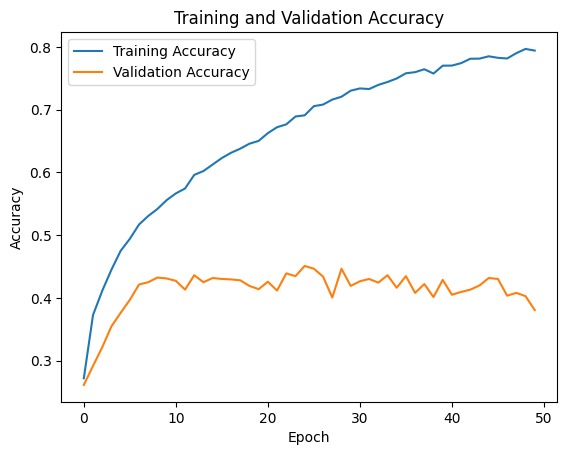

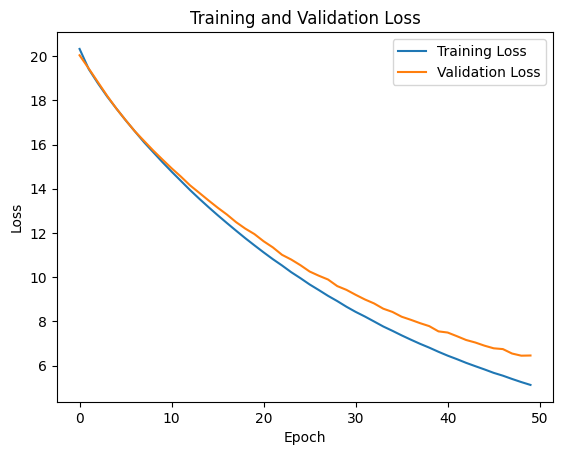

In [ ]:
# Plot training and validation accuracy
plt.plot(histories[len(histories)-1].history['accuracy'], label='Training Accuracy')
plt.plot(histories[len(histories)-1].history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.savefig("EfficientNet-50epochs-TrainingandValidationAccuracy.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot training and validation loss
plt.plot(histories[len(histories)-1].history['loss'], label='Training Loss')
plt.plot(histories[len(histories)-1].history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.savefig("EfficientNet-50epochs-TrainingandValidationLoss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
model = createModel(modelType=ModelType.EfficientNet,regularizer={"type":RegularizationType.L2,"value":0.01},optimizer=getOptimizer(type=OptimizerType.Sgd,learningRate=0.01), loss='categorical_crossentropy', metrics=['accuracy'],seed=123, augmentation=AugmentationTechnique.NoAugmentation)
# train the model
history = model.fit(batch_size=128,epochs=10, train_images=train_images,train_labels=train_labels,valid_images=valid_images,valid_labels=valid_labels)

# get accuracy
y_pred = model.predict(test_images)
# Convert probabilities to class labels
predicted_classes = np.argmax(y_pred, axis=1)

# Get true class labels
true_classes = np.argmax(test_labels, axis=1)
accuracy = getAccuracy(predicted_classes,true_classes)


Epoch 1/10
1477/1477 [==============================] - 28s 15ms/step - loss: 15.5864 - accuracy: 0.4020 - val_loss: 11.7338 - val_accuracy: 0.4497
Epoch 2/10
1477/1477 [==============================] - 19s 13ms/step - loss: 9.2426 - accuracy: 0.4529 - val_loss: 7.1741 - val_accuracy: 0.4637
Epoch 3/10
1477/1477 [==============================] - 20s 13ms/step - loss: 5.7917 - accuracy: 0.4646 - val_loss: 4.6652 - val_accuracy: 0.4659
Epoch 4/10
1477/1477 [==============================] - 20s 14ms/step - loss: 3.8937 - accuracy: 0.4700 - val_loss: 3.3169 - val_accuracy: 0.4540
Epoch 5/10
1477/1477 [==============================] - 20s 13ms/step - loss: 2.8478 - accuracy: 0.4714 - val_loss: 2.5222 - val_accuracy: 0.4679
Epoch 6/10
1477/1477 [==============================] - 19s 13ms/step - loss: 2.2747 - accuracy: 0.4715 - val_loss: 2.1777 - val_accuracy: 0.4451
Epoch 7/10
1477/1477 [==============================] - 20s 14ms/step - loss: 1.9556 - accuracy: 0.4739 - val_loss: 1.9552

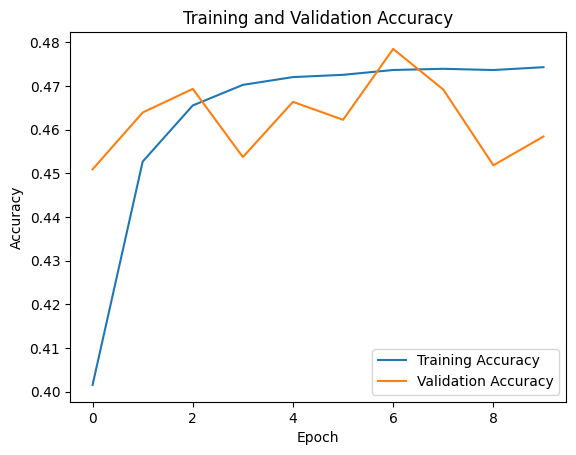

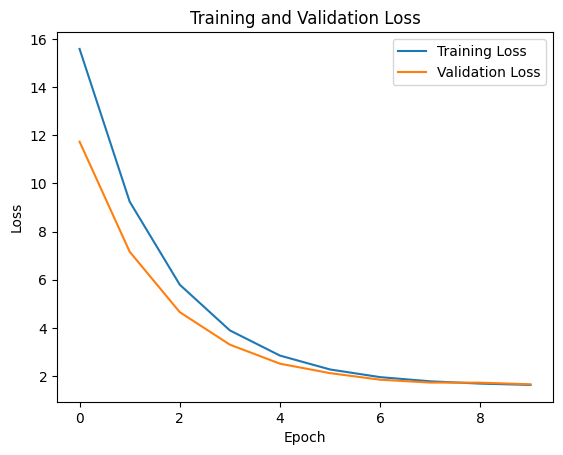

1688/1688 [==============================] - 15s 8ms/step


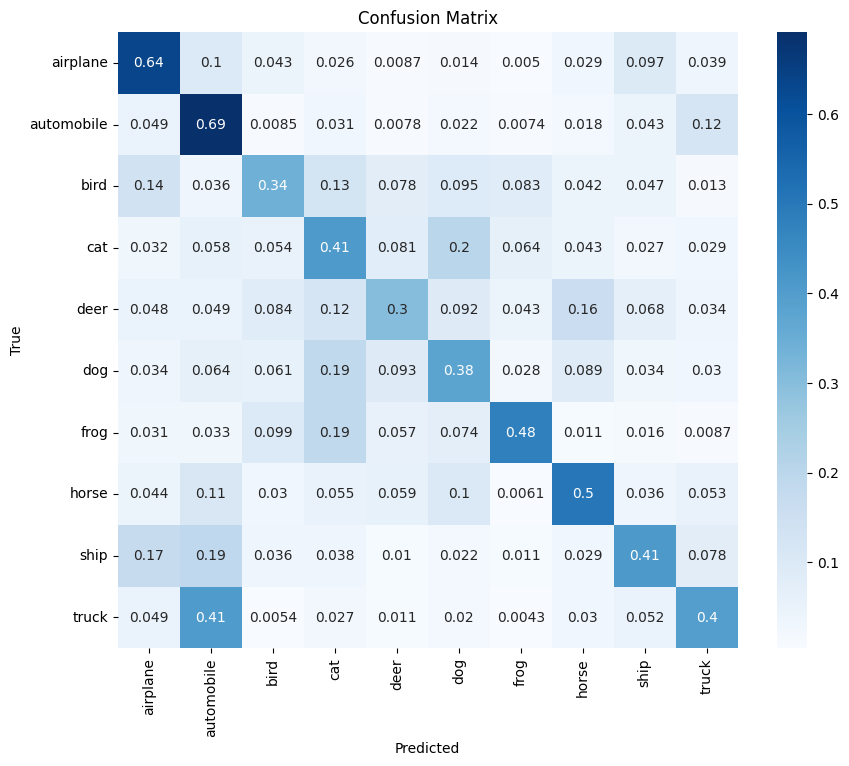

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig("EfficientNet-TrainingandValidationAccuracy.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("EfficientNet-TrainingandValidationLoss.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Predict probabilities for test data
predictions = model.predict(test_images)
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = np.argmax(test_labels, axis=1)

# Get class labels
class_labels = sorted(os.listdir(test_data_dir))
class_labels = [class_name for class_name in class_labels if class_name != '.DS_Store']

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("EfficientNet-ConfusionMatrix.pdf", format="pdf", bbox_inches="tight")
plt.show()



In [ ]:
with open("efficientnet-history","wb") as my_csv:
    pickle.dump(history,my_csv)

In [15]:
results, best, histories = performExperiment(modelType=ModelType.MobileNet,batchSizes=batchSizes,learningRates=learningRates,numberOfEpochs=numberOfEpochs,augmentationTechniques=augmentationTechniques,regularizers=regularizers,seeds=seeds, optimizerType=OptimizerType.Adam)


Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 9s 32ms/step - loss: 2.5119 - accuracy: 0.1785 - val_loss: 24.9932 - val_accuracy: 0.0889
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 2.1988 - accuracy: 0.2315 - val_loss: 7.3235 - val_accuracy: 0.0933
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 2.1005 - accuracy: 0.2480 - val_loss: 3.7309 - val_accuracy: 0.1296
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.0404 - accuracy: 0.2653 - val_loss: 4.0483 - val_accuracy: 0.1496
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.0838 - accuracy: 0.2641 - val_loss: 9.6315 - val_accuracy: 0.1089
Epoch 6/10
74/74 [==============================] 

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 7s 30ms/step - loss: 2.5146 - accuracy: 0.1804 - val_loss: 23.0128 - val_accuracy: 0.0889
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2062 - accuracy: 0.2246 - val_loss: 10.0682 - val_accuracy: 0.1133
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 2.1135 - accuracy: 0.2511 - val_loss: 10.8940 - val_accuracy: 0.1030
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.0812 - accuracy: 0.2636 - val_loss: 11.3348 - val_accuracy: 0.1111
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.0328 - accuracy: 0.2735 - val_loss: 2.9330 - val_accuracy: 0.1859
Epoch 6/10
74/74 [==============================

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 7s 31ms/step - loss: 2.4417 - accuracy: 0.1823 - val_loss: 28.7788 - val_accuracy: 0.1222
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 2.1920 - accuracy: 0.2276 - val_loss: 14.9873 - val_accuracy: 0.1378
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 2.1288 - accuracy: 0.2467 - val_loss: 6.5155 - val_accuracy: 0.1607
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.0774 - accuracy: 0.2702 - val_loss: 7.6594 - val_accuracy: 0.0904
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.0362 - accuracy: 0.2750 - val_loss: 7.0438 - val_accuracy: 0.1081
Epoch 6/10
74/74 [==============================] -

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Rotation, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 33s 59ms/step - loss: 2.7911 - accuracy: 0.1239 - val_loss: 321782592.0000 - val_accuracy: 0.0874
Epoch 2/10
74/74 [==============================] - 3s 39ms/step - loss: 2.5803 - accuracy: 0.1154 - val_loss: 67912286208.0000 - val_accuracy: 0.0993
Epoch 3/10
74/74 [==============================] - 3s 39ms/step - loss: 2.4692 - accuracy: 0.1413 - val_loss: 8162192384.0000 - val_accuracy: 0.0889
Epoch 4/10
74/74 [==============================] - 3s 42ms/step - loss: 2.2894 - accuracy: 0.1758 - val_loss: 5305350144.0000 - val_accuracy: 0.1089
Epoch 5/10
74/74 [==============================] - 3s 41ms/step - loss: 2.2364 - accuracy: 0.2016 - val_loss: 718828672.0000 - val_accuracy: 0.1037
Epoch 6/10
7

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Rotation, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 30s 70ms/step - loss: 2.7189 - accuracy: 0.1236 - val_loss: 38807228416.0000 - val_accuracy: 0.1037
Epoch 2/10
74/74 [==============================] - 3s 42ms/step - loss: 2.5315 - accuracy: 0.1396 - val_loss: 61833170944.0000 - val_accuracy: 0.0889
Epoch 3/10
74/74 [==============================] - 3s 41ms/step - loss: 2.5606 - accuracy: 0.1503 - val_loss: 17888522240.0000 - val_accuracy: 0.1133
Epoch 4/10
74/74 [==============================] - 3s 44ms/step - loss: 2.4734 - accuracy: 0.1465 - val_loss: 3126648064.0000 - val_accuracy: 0.0874
Epoch 5/10
74/74 [==============================] - 3s 41ms/step - loss: 2.2401 - accuracy: 0.2035 - val_loss: 129713520.0000 - val_accuracy: 0.0993
Epoch 6/10

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Rotation, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 29s 60ms/step - loss: 2.7720 - accuracy: 0.1343 - val_loss: 116272456.0000 - val_accuracy: 0.1037
Epoch 2/10
74/74 [==============================] - 3s 42ms/step - loss: 2.5453 - accuracy: 0.1366 - val_loss: 14857439232.0000 - val_accuracy: 0.1037
Epoch 3/10
74/74 [==============================] - 3s 43ms/step - loss: 2.5493 - accuracy: 0.1254 - val_loss: 93449101312.0000 - val_accuracy: 0.0874
Epoch 4/10
74/74 [==============================] - 3s 42ms/step - loss: 2.4661 - accuracy: 0.1235 - val_loss: 2587824128.0000 - val_accuracy: 0.1089
Epoch 5/10
74/74 [==============================] - 3s 41ms/step - loss: 2.3902 - accuracy: 0.1251 - val_loss: 47043320.0000 - val_accuracy: 0.0874
Epoch 6/10
74/

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Flipping, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 30s 60ms/step - loss: 2.7454 - accuracy: 0.1520 - val_loss: 13066804224.0000 - val_accuracy: 0.0874
Epoch 2/10
74/74 [==============================] - 3s 46ms/step - loss: 2.4371 - accuracy: 0.1886 - val_loss: 265736448.0000 - val_accuracy: 0.1022
Epoch 3/10
74/74 [==============================] - 3s 43ms/step - loss: 2.3766 - accuracy: 0.1619 - val_loss: 59823337472.0000 - val_accuracy: 0.0874
Epoch 4/10
74/74 [==============================] - 3s 43ms/step - loss: 2.4011 - accuracy: 0.1352 - val_loss: 11805231104.0000 - val_accuracy: 0.0874
Epoch 5/10
74/74 [==============================] - 3s 44ms/step - loss: 2.3438 - accuracy: 0.1344 - val_loss: 2077943680.0000 - val_accuracy: 0.0874
Epoch 6/1

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Flipping, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 29s 60ms/step - loss: 2.6419 - accuracy: 0.1643 - val_loss: 13739416576.0000 - val_accuracy: 0.1059
Epoch 2/10
74/74 [==============================] - 3s 42ms/step - loss: 2.4565 - accuracy: 0.1729 - val_loss: 1438534784.0000 - val_accuracy: 0.1022
Epoch 3/10
74/74 [==============================] - 3s 42ms/step - loss: 2.4851 - accuracy: 0.1313 - val_loss: 174784397312.0000 - val_accuracy: 0.1133
Epoch 4/10
74/74 [==============================] - 3s 43ms/step - loss: 2.4438 - accuracy: 0.1567 - val_loss: 267196368.0000 - val_accuracy: 0.1089
Epoch 5/10
74/74 [==============================] - 3s 43ms/step - loss: 2.3783 - accuracy: 0.1444 - val_loss: 44543180.0000 - val_accuracy: 0.0993
Epoch 6/10
7

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Flipping, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 29s 59ms/step - loss: 2.6491 - accuracy: 0.1568 - val_loss: 5813665280.0000 - val_accuracy: 0.1059
Epoch 2/10
74/74 [==============================] - 3s 43ms/step - loss: 2.4259 - accuracy: 0.1737 - val_loss: 12407872512.0000 - val_accuracy: 0.1037
Epoch 3/10
74/74 [==============================] - 3s 45ms/step - loss: 2.4536 - accuracy: 0.1719 - val_loss: 36259627008.0000 - val_accuracy: 0.1133
Epoch 4/10
74/74 [==============================] - 3s 43ms/step - loss: 2.2600 - accuracy: 0.1806 - val_loss: 62677647360.0000 - val_accuracy: 0.1022
Epoch 5/10
74/74 [==============================] - 3s 43ms/step - loss: 2.2172 - accuracy: 0.1957 - val_loss: 2411004672.0000 - val_accuracy: 0.1037
Epoch 6/10

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Zoom, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 29s 59ms/step - loss: 2.7044 - accuracy: 0.1414 - val_loss: 174447050752.0000 - val_accuracy: 0.1022
Epoch 2/10
74/74 [==============================] - 3s 44ms/step - loss: 2.5585 - accuracy: 0.1497 - val_loss: 70899810304.0000 - val_accuracy: 0.0889
Epoch 3/10
74/74 [==============================] - 3s 43ms/step - loss: 2.4669 - accuracy: 0.1572 - val_loss: 1012116032.0000 - val_accuracy: 0.1007
Epoch 4/10
74/74 [==============================] - 3s 42ms/step - loss: 2.3245 - accuracy: 0.1728 - val_loss: 23296172.0000 - val_accuracy: 0.0874
Epoch 5/10
74/74 [==============================] - 3s 42ms/step - loss: 2.2184 - accuracy: 0.2060 - val_loss: 8187586.0000 - val_accuracy: 0.1037
Epoch 6/10
74/74 

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Zoom, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 29s 61ms/step - loss: 2.7607 - accuracy: 0.1433 - val_loss: 13839940608.0000 - val_accuracy: 0.0889
Epoch 2/10
74/74 [==============================] - 3s 43ms/step - loss: 2.4472 - accuracy: 0.1764 - val_loss: 29554026496.0000 - val_accuracy: 0.1133
Epoch 3/10
74/74 [==============================] - 3s 43ms/step - loss: 2.3187 - accuracy: 0.1989 - val_loss: 64233984000.0000 - val_accuracy: 0.0889
Epoch 4/10
74/74 [==============================] - 3s 44ms/step - loss: 2.2921 - accuracy: 0.1782 - val_loss: 8621894656.0000 - val_accuracy: 0.1037
Epoch 5/10
74/74 [==============================] - 3s 44ms/step - loss: 2.2246 - accuracy: 0.2091 - val_loss: 280558560.0000 - val_accuracy: 0.1037
Epoch 6/10
74/

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Zoom, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 29s 60ms/step - loss: 2.7300 - accuracy: 0.1352 - val_loss: 361607904.0000 - val_accuracy: 0.1007
Epoch 2/10
74/74 [==============================] - 3s 43ms/step - loss: 2.4767 - accuracy: 0.1560 - val_loss: 3575860992.0000 - val_accuracy: 0.0874
Epoch 3/10
74/74 [==============================] - 3s 45ms/step - loss: 2.4952 - accuracy: 0.1301 - val_loss: 2079726108672.0000 - val_accuracy: 0.1059
Epoch 4/10
74/74 [==============================] - 3s 42ms/step - loss: 2.4582 - accuracy: 0.1159 - val_loss: 62265118720.0000 - val_accuracy: 0.1059
Epoch 5/10
74/74 [==============================] - 3s 42ms/step - loss: 2.4493 - accuracy: 0.1279 - val_loss: 1107597056.0000 - val_accuracy: 0.1133
Epoch 6/10
74/

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Brightness, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 31s 61ms/step - loss: 2.7329 - accuracy: 0.1052 - val_loss: 152788768.0000 - val_accuracy: 0.0889
Epoch 2/10
74/74 [==============================] - 3s 41ms/step - loss: 2.6140 - accuracy: 0.1038 - val_loss: 12682537984.0000 - val_accuracy: 0.1059
Epoch 3/10
74/74 [==============================] - 3s 41ms/step - loss: 2.5956 - accuracy: 0.0981 - val_loss: 5625835520.0000 - val_accuracy: 0.0993
Epoch 4/10
74/74 [==============================] - 3s 42ms/step - loss: 2.4833 - accuracy: 0.1013 - val_loss: 993928960.0000 - val_accuracy: 0.1037
Epoch 5/10
74/74 [==============================] - 3s 44ms/step - loss: 2.4646 - accuracy: 0.1023 - val_loss: 36392500.0000 - val_accuracy: 0.0896
Epoch 6/10
7

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Brightness, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 29s 60ms/step - loss: 2.8011 - accuracy: 0.1007 - val_loss: 10722219008.0000 - val_accuracy: 0.1037
Epoch 2/10
74/74 [==============================] - 3s 43ms/step - loss: 2.6180 - accuracy: 0.1019 - val_loss: 125698336.0000 - val_accuracy: 0.0993
Epoch 3/10
74/74 [==============================] - 3s 42ms/step - loss: 2.6326 - accuracy: 0.1058 - val_loss: 58768808.0000 - val_accuracy: 0.1037
Epoch 4/10
74/74 [==============================] - 3s 44ms/step - loss: 2.4204 - accuracy: 0.1039 - val_loss: 12262970368.0000 - val_accuracy: 0.1059
Epoch 5/10
74/74 [==============================] - 3s 42ms/step - loss: 2.3917 - accuracy: 0.0985 - val_loss: 43826560.0000 - val_accuracy: 0.1022
Epoch 6/10
74

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.Brightness, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 29s 56ms/step - loss: 2.8512 - accuracy: 0.0995 - val_loss: 25606762496.0000 - val_accuracy: 0.0889
Epoch 2/10
74/74 [==============================] - 3s 41ms/step - loss: 2.6654 - accuracy: 0.0995 - val_loss: 360662752.0000 - val_accuracy: 0.1007
Epoch 3/10
74/74 [==============================] - 3s 42ms/step - loss: 2.5036 - accuracy: 0.1035 - val_loss: 8351384.5000 - val_accuracy: 0.1133
Epoch 4/10
74/74 [==============================] - 3s 40ms/step - loss: 2.4786 - accuracy: 0.1022 - val_loss: 1583410.2500 - val_accuracy: 0.0896
Epoch 5/10
74/74 [==============================] - 3s 40ms/step - loss: 2.4662 - accuracy: 0.0969 - val_loss: 16273998.0000 - val_accuracy: 0.0889
Epoch 6/10
74/74 [=

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.RandomErasing, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 31s 63ms/step - loss: 2.7942 - accuracy: 0.1200 - val_loss: 5625847296.0000 - val_accuracy: 0.1007
Epoch 2/10
74/74 [==============================] - 3s 42ms/step - loss: 2.6141 - accuracy: 0.1138 - val_loss: 80717296.0000 - val_accuracy: 0.1059
Epoch 3/10
74/74 [==============================] - 3s 43ms/step - loss: 2.5405 - accuracy: 0.1153 - val_loss: 47488252.0000 - val_accuracy: 0.1007
Epoch 4/10
74/74 [==============================] - 3s 44ms/step - loss: 2.4885 - accuracy: 0.1135 - val_loss: 206626320.0000 - val_accuracy: 0.0874
Epoch 5/10
74/74 [==============================] - 3s 42ms/step - loss: 2.4073 - accuracy: 0.1184 - val_loss: 4740479.5000 - val_accuracy: 0.1133
Epoch 6/10
74/

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.RandomErasing, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 32s 96ms/step - loss: 2.5648 - accuracy: 0.1593 - val_loss: 2711594752.0000 - val_accuracy: 0.1022
Epoch 2/10
74/74 [==============================] - 3s 43ms/step - loss: 2.4344 - accuracy: 0.1579 - val_loss: 2846596.0000 - val_accuracy: 0.1007
Epoch 3/10
74/74 [==============================] - 3s 42ms/step - loss: 2.5649 - accuracy: 0.1241 - val_loss: 721124288.0000 - val_accuracy: 0.0874
Epoch 4/10
74/74 [==============================] - 3s 44ms/step - loss: 2.3154 - accuracy: 0.1707 - val_loss: 246997952.0000 - val_accuracy: 0.1037
Epoch 5/10
74/74 [==============================] - 3s 42ms/step - loss: 2.2327 - accuracy: 0.1935 - val_loss: 104905256.0000 - val_accuracy: 0.1059
Epoch 6/10
74

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.RandomErasing, regularizer: {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 30s 64ms/step - loss: 2.7059 - accuracy: 0.1354 - val_loss: 9887503360.0000 - val_accuracy: 0.1059
Epoch 2/10
74/74 [==============================] - 3s 46ms/step - loss: 2.4317 - accuracy: 0.1656 - val_loss: 5012196352.0000 - val_accuracy: 0.1133
Epoch 3/10
74/74 [==============================] - 3s 44ms/step - loss: 2.4295 - accuracy: 0.1685 - val_loss: 82123352.0000 - val_accuracy: 0.0889
Epoch 4/10
74/74 [==============================] - 3s 43ms/step - loss: 2.3222 - accuracy: 0.1705 - val_loss: 724675.0625 - val_accuracy: 0.0993
Epoch 5/10
74/74 [==============================] - 3s 44ms/step - loss: 2.2777 - accuracy: 0.1812 - val_loss: 343071.0938 - val_accuracy: 0.0874
Epoch 6/10
74/74 [

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 7s 31ms/step - loss: 2.8082 - accuracy: 0.1298 - val_loss: 5.1785 - val_accuracy: 0.1089
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 2.4185 - accuracy: 0.1506 - val_loss: 2.5555 - val_accuracy: 0.1467
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3398 - accuracy: 0.1639 - val_loss: 2.1971 - val_accuracy: 0.2000
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2753 - accuracy: 0.1725 - val_loss: 2.2630 - val_accuracy: 0.1800
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2396 - accuracy: 0.1829 - val_loss: 2.1772 - val_accuracy: 0.1822
Epoch 6/10
74/74 [==============================] - 1s 13m

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 7s 31ms/step - loss: 2.8266 - accuracy: 0.1365 - val_loss: 4.2722 - val_accuracy: 0.1170
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 2.4461 - accuracy: 0.1398 - val_loss: 2.3563 - val_accuracy: 0.1800
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3351 - accuracy: 0.1611 - val_loss: 2.1988 - val_accuracy: 0.1704
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2624 - accuracy: 0.1771 - val_loss: 2.2931 - val_accuracy: 0.1741
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2322 - accuracy: 0.1828 - val_loss: 2.1981 - val_accuracy: 0.1822
Epoch 6/10
74/74 [==============================] - 1s 13ms

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 7s 31ms/step - loss: 2.8098 - accuracy: 0.1275 - val_loss: 4.0337 - val_accuracy: 0.1200
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 2.4414 - accuracy: 0.1484 - val_loss: 2.5964 - val_accuracy: 0.1674
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3229 - accuracy: 0.1687 - val_loss: 2.2014 - val_accuracy: 0.1800
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2889 - accuracy: 0.1688 - val_loss: 2.1984 - val_accuracy: 0.1867
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2277 - accuracy: 0.1832 - val_loss: 2.1568 - val_accuracy: 0.2178
Epoch 6/10
74/74 [==============================] - 1s 13ms/

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.5}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 8s 32ms/step - loss: 3.0124 - accuracy: 0.1192 - val_loss: 3.0127 - val_accuracy: 0.1370
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 2.4917 - accuracy: 0.1325 - val_loss: 2.3531 - val_accuracy: 0.1541
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3879 - accuracy: 0.1380 - val_loss: 2.2559 - val_accuracy: 0.1681
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3100 - accuracy: 0.1440 - val_loss: 2.2064 - val_accuracy: 0.1756
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2695 - accuracy: 0.1535 - val_loss: 2.1970 - val_accuracy: 0.1637
Epoch 6/10
74/74 [==============================] - 1s 12m

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.5}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 11s 33ms/step - loss: 2.9883 - accuracy: 0.1152 - val_loss: 3.5810 - val_accuracy: 0.1148
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 2.5015 - accuracy: 0.1328 - val_loss: 2.3236 - val_accuracy: 0.1437
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3947 - accuracy: 0.1372 - val_loss: 2.3092 - val_accuracy: 0.1437
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3167 - accuracy: 0.1469 - val_loss: 2.2208 - val_accuracy: 0.1719
Epoch 5/10
74/74 [==============================] - 1s 13ms/step - loss: 2.2680 - accuracy: 0.1558 - val_loss: 2.1981 - val_accuracy: 0.1615
Epoch 6/10
74/74 [==============================] - 1s 13m

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.5}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 8s 32ms/step - loss: 2.9868 - accuracy: 0.1195 - val_loss: 4.3345 - val_accuracy: 0.1230
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 2.5064 - accuracy: 0.1278 - val_loss: 2.4156 - val_accuracy: 0.1148
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 2.3883 - accuracy: 0.1354 - val_loss: 2.2457 - val_accuracy: 0.1563
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3154 - accuracy: 0.1480 - val_loss: 2.2085 - val_accuracy: 0.1689
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.2667 - accuracy: 0.1604 - val_loss: 2.2107 - val_accuracy: 0.1711
Epoch 6/10
74/74 [==============================] - 1s 12ms/

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.8}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 7s 33ms/step - loss: 3.6740 - accuracy: 0.1029 - val_loss: 2.3145 - val_accuracy: 0.1178
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 2.7197 - accuracy: 0.1061 - val_loss: 2.3164 - val_accuracy: 0.1185
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 2.5206 - accuracy: 0.1076 - val_loss: 2.3133 - val_accuracy: 0.1141
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.4172 - accuracy: 0.1101 - val_loss: 2.3193 - val_accuracy: 0.0941
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.3476 - accuracy: 0.1131 - val_loss: 2.3150 - val_accuracy: 0.1022
Epoch 6/10
74/74 [==============================] - 1s 12m

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.8}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 7s 31ms/step - loss: 3.6536 - accuracy: 0.1058 - val_loss: 2.3359 - val_accuracy: 0.1089
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 2.7213 - accuracy: 0.1060 - val_loss: 2.2796 - val_accuracy: 0.1319
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.5317 - accuracy: 0.1072 - val_loss: 2.2994 - val_accuracy: 0.1215
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.4051 - accuracy: 0.1152 - val_loss: 2.3075 - val_accuracy: 0.1059
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.3433 - accuracy: 0.1145 - val_loss: 2.3098 - val_accuracy: 0.1030
Epoch 6/10
74/74 [==============================] - 1s 12ms

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.8}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 7s 32ms/step - loss: 3.6840 - accuracy: 0.1066 - val_loss: 2.2714 - val_accuracy: 0.1437
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 2.7073 - accuracy: 0.1130 - val_loss: 2.3142 - val_accuracy: 0.1363
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.5252 - accuracy: 0.1091 - val_loss: 2.3119 - val_accuracy: 0.1089
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.4080 - accuracy: 0.1099 - val_loss: 2.3123 - val_accuracy: 0.0933
Epoch 5/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3507 - accuracy: 0.1109 - val_loss: 2.3087 - val_accuracy: 0.1111
Epoch 6/10
74/74 [==============================] - 1s 13ms/

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.001}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 7s 32ms/step - loss: 3.7678 - accuracy: 0.1792 - val_loss: 12.6707 - val_accuracy: 0.1274
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 2.6853 - accuracy: 0.2259 - val_loss: 6.2639 - val_accuracy: 0.1074
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.5005 - accuracy: 0.2347 - val_loss: 2.8401 - val_accuracy: 0.1511
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.4057 - accuracy: 0.2426 - val_loss: 3.9533 - val_accuracy: 0.1474
Epoch 5/10
74/74 [==============================] - 1s 13ms/step - loss: 2.3756 - accuracy: 0.2579 - val_loss: 5.7965 - val_accuracy: 0.1044
Epoch 6/10
74/74 [==============================] - 1s 13ms/

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.001}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 7s 32ms/step - loss: 3.7163 - accuracy: 0.1831 - val_loss: 15.9047 - val_accuracy: 0.1104
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 2.6632 - accuracy: 0.2257 - val_loss: 6.0409 - val_accuracy: 0.1222
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 2.4829 - accuracy: 0.2325 - val_loss: 5.9517 - val_accuracy: 0.1163
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.4247 - accuracy: 0.2360 - val_loss: 3.4139 - val_accuracy: 0.1259
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.3708 - accuracy: 0.2480 - val_loss: 5.9905 - val_accuracy: 0.1074
Epoch 6/10
74/74 [==============================] - 1s 13ms/s

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.001}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 11s 33ms/step - loss: 3.6674 - accuracy: 0.1875 - val_loss: 16.6774 - val_accuracy: 0.0889
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 2.7084 - accuracy: 0.2217 - val_loss: 9.0991 - val_accuracy: 0.1467
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.5274 - accuracy: 0.2346 - val_loss: 3.1869 - val_accuracy: 0.1341
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.4633 - accuracy: 0.2460 - val_loss: 3.4829 - val_accuracy: 0.1333
Epoch 5/10
74/74 [==============================] - 1s 14ms/step - loss: 2.3872 - accuracy: 0.2476 - val_loss: 2.8186 - val_accuracy: 0.1622
Epoch 6/10
74/74 [==============================] - 1s 13ms/s

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.01}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 8s 33ms/step - loss: 6.3492 - accuracy: 0.1830 - val_loss: 5.3694 - val_accuracy: 0.0948
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 3.3860 - accuracy: 0.2135 - val_loss: 3.8669 - val_accuracy: 0.0985
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 2.9925 - accuracy: 0.2210 - val_loss: 3.3465 - val_accuracy: 0.1289
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.7742 - accuracy: 0.2273 - val_loss: 3.0158 - val_accuracy: 0.1096
Epoch 5/10
74/74 [==============================] - 1s 14ms/step - loss: 2.5725 - accuracy: 0.2413 - val_loss: 3.0590 - val_accuracy: 0.0941
Epoch 6/10
74/74 [==============================] - 1s 14ms/st

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.01}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 7s 31ms/step - loss: 6.2046 - accuracy: 0.1826 - val_loss: 5.5075 - val_accuracy: 0.0948
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 3.3945 - accuracy: 0.2055 - val_loss: 4.7257 - val_accuracy: 0.0985
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 3.0265 - accuracy: 0.2116 - val_loss: 5.4036 - val_accuracy: 0.1067
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 2.8107 - accuracy: 0.2096 - val_loss: 3.1154 - val_accuracy: 0.1067
Epoch 5/10
74/74 [==============================] - 1s 13ms/step - loss: 2.5567 - accuracy: 0.2340 - val_loss: 3.1508 - val_accuracy: 0.1459
Epoch 6/10
74/74 [==============================] - 1s 13ms/ste

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.01}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 7s 32ms/step - loss: 6.2588 - accuracy: 0.1766 - val_loss: 4.4308 - val_accuracy: 0.1007
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 3.3878 - accuracy: 0.1994 - val_loss: 4.8908 - val_accuracy: 0.1022
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 3.0990 - accuracy: 0.2138 - val_loss: 4.4880 - val_accuracy: 0.1096
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 2.8639 - accuracy: 0.2216 - val_loss: 2.9584 - val_accuracy: 0.1244
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 2.5343 - accuracy: 0.2344 - val_loss: 2.6573 - val_accuracy: 0.1630
Epoch 6/10
74/74 [==============================] - 1s 13ms/step

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.1}, learning rate: 0.01, seed: 123
Epoch 1/10
74/74 [==============================] - 7s 31ms/step - loss: 15.2688 - accuracy: 0.1667 - val_loss: 3.7666 - val_accuracy: 0.0874
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 3.7050 - accuracy: 0.1896 - val_loss: 4.3211 - val_accuracy: 0.0993
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 3.8093 - accuracy: 0.1859 - val_loss: 4.5674 - val_accuracy: 0.0889
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 3.5065 - accuracy: 0.1905 - val_loss: 4.2483 - val_accuracy: 0.1052
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 3.3326 - accuracy: 0.1957 - val_loss: 3.3294 - val_accuracy: 0.0904
Epoch 6/10
74/74 [==============================] - 1s 13ms/st

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.1}, learning rate: 0.01, seed: 42
Epoch 1/10
74/74 [==============================] - 7s 32ms/step - loss: 14.9750 - accuracy: 0.1690 - val_loss: 3.9321 - val_accuracy: 0.1044
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 3.8454 - accuracy: 0.1815 - val_loss: 4.2794 - val_accuracy: 0.1037
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 3.7829 - accuracy: 0.1821 - val_loss: 5.6586 - val_accuracy: 0.0985
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 3.6436 - accuracy: 0.1890 - val_loss: 3.6117 - val_accuracy: 0.1348
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 3.3824 - accuracy: 0.1935 - val_loss: 3.6861 - val_accuracy: 0.1089
Epoch 6/10
74/74 [==============================] - 1s 13ms/ste

Performing experiment with model: ModelType.MobileNet, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.L2: 2>, 'value': 0.1}, learning rate: 0.01, seed: 9
Epoch 1/10
74/74 [==============================] - 7s 32ms/step - loss: 15.1486 - accuracy: 0.1667 - val_loss: 3.8126 - val_accuracy: 0.1030
Epoch 2/10
74/74 [==============================] - 1s 12ms/step - loss: 3.7869 - accuracy: 0.1713 - val_loss: 4.2222 - val_accuracy: 0.1022
Epoch 3/10
74/74 [==============================] - 1s 12ms/step - loss: 3.6906 - accuracy: 0.1871 - val_loss: 5.6858 - val_accuracy: 0.1022
Epoch 4/10
74/74 [==============================] - 1s 12ms/step - loss: 3.4517 - accuracy: 0.1954 - val_loss: 4.3805 - val_accuracy: 0.1022
Epoch 5/10
74/74 [==============================] - 1s 12ms/step - loss: 3.2364 - accuracy: 0.1930 - val_loss: 6.7914 - val_accuracy: 0.1037
Epoch 6/10
74/74 [==============================] - 1s 13ms/step

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 123
Epoch 1/10
148/148 [==============================] - 9s 23ms/step - loss: 2.7945 - accuracy: 0.1291 - val_loss: 2.8400 - val_accuracy: 0.1496
Epoch 2/10
148/148 [==============================] - 2s 11ms/step - loss: 2.4116 - accuracy: 0.1508 - val_loss: 2.3993 - val_accuracy: 0.1348
Epoch 3/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2763 - accuracy: 0.1653 - val_loss: 2.1751 - val_accuracy: 0.1800
Epoch 4/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2091 - accuracy: 0.1799 - val_loss: 2.1557 - val_accuracy: 0.1978
Epoch 5/10
148/148 [==============================] - 2s 11ms/step - loss: 2.1796 - accuracy: 0.1910 - val_loss: 2.1511 - val_accuracy: 0.2074
Epoch 6/10
148/148 [=============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 42
Epoch 1/10
148/148 [==============================] - 12s 22ms/step - loss: 2.8261 - accuracy: 0.1313 - val_loss: 2.9861 - val_accuracy: 0.1370
Epoch 2/10
148/148 [==============================] - 2s 12ms/step - loss: 2.3945 - accuracy: 0.1551 - val_loss: 2.2244 - val_accuracy: 0.1778
Epoch 3/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2600 - accuracy: 0.1654 - val_loss: 2.1713 - val_accuracy: 0.1793
Epoch 4/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2101 - accuracy: 0.1818 - val_loss: 2.1747 - val_accuracy: 0.1852
Epoch 5/10
148/148 [==============================] - 2s 11ms/step - loss: 2.1770 - accuracy: 0.1919 - val_loss: 2.1311 - val_accuracy: 0.1926
Epoch 6/10
148/148 [=============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 9
Epoch 1/10
148/148 [==============================] - 9s 21ms/step - loss: 2.7834 - accuracy: 0.1294 - val_loss: 2.7982 - val_accuracy: 0.1281
Epoch 2/10
148/148 [==============================] - 2s 12ms/step - loss: 2.4201 - accuracy: 0.1506 - val_loss: 2.2549 - val_accuracy: 0.1711
Epoch 3/10
148/148 [==============================] - 2s 12ms/step - loss: 2.2671 - accuracy: 0.1726 - val_loss: 2.1941 - val_accuracy: 0.1881
Epoch 4/10
148/148 [==============================] - 2s 13ms/step - loss: 2.1972 - accuracy: 0.1807 - val_loss: 2.1598 - val_accuracy: 0.2111
Epoch 5/10
148/148 [==============================] - 2s 12ms/step - loss: 2.1733 - accuracy: 0.1932 - val_loss: 2.1318 - val_accuracy: 0.2244
Epoch 6/10
148/148 [==============================]

Performing experiment with model: ModelType.MobileNet, batch size: 32, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 123
Epoch 1/10
296/296 [==============================] - 10s 16ms/step - loss: 2.8211 - accuracy: 0.1305 - val_loss: 2.2773 - val_accuracy: 0.1607
Epoch 2/10
296/296 [==============================] - 3s 11ms/step - loss: 2.3107 - accuracy: 0.1622 - val_loss: 2.2148 - val_accuracy: 0.1748
Epoch 3/10
296/296 [==============================] - 3s 11ms/step - loss: 2.2124 - accuracy: 0.1746 - val_loss: 2.1763 - val_accuracy: 0.1852
Epoch 4/10
296/296 [==============================] - 3s 11ms/step - loss: 2.1950 - accuracy: 0.1800 - val_loss: 2.1753 - val_accuracy: 0.1822
Epoch 5/10
296/296 [==============================] - 3s 11ms/step - loss: 2.1825 - accuracy: 0.1842 - val_loss: 2.1553 - val_accuracy: 0.1889
Epoch 6/10
296/296 [============================

Performing experiment with model: ModelType.MobileNet, batch size: 32, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 42
Epoch 1/10
296/296 [==============================] - 10s 16ms/step - loss: 2.8022 - accuracy: 0.1320 - val_loss: 2.3289 - val_accuracy: 0.1593
Epoch 2/10
296/296 [==============================] - 3s 11ms/step - loss: 2.3182 - accuracy: 0.1578 - val_loss: 2.2064 - val_accuracy: 0.1748
Epoch 3/10
296/296 [==============================] - 3s 11ms/step - loss: 2.2135 - accuracy: 0.1793 - val_loss: 2.1935 - val_accuracy: 0.1778
Epoch 4/10
296/296 [==============================] - 3s 12ms/step - loss: 2.1922 - accuracy: 0.1838 - val_loss: 2.2012 - val_accuracy: 0.1741
Epoch 5/10
296/296 [==============================] - 3s 11ms/step - loss: 2.1818 - accuracy: 0.1876 - val_loss: 2.1391 - val_accuracy: 0.2081
Epoch 6/10
296/296 [=============================

Performing experiment with model: ModelType.MobileNet, batch size: 32, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.01, seed: 9
Epoch 1/10
296/296 [==============================] - 10s 16ms/step - loss: 2.8180 - accuracy: 0.1223 - val_loss: 2.2759 - val_accuracy: 0.1733
Epoch 2/10
296/296 [==============================] - 3s 11ms/step - loss: 2.3038 - accuracy: 0.1558 - val_loss: 2.1882 - val_accuracy: 0.1807
Epoch 3/10
296/296 [==============================] - 3s 11ms/step - loss: 2.2093 - accuracy: 0.1799 - val_loss: 2.2920 - val_accuracy: 0.1259
Epoch 4/10
296/296 [==============================] - 3s 11ms/step - loss: 2.1882 - accuracy: 0.1818 - val_loss: 2.1377 - val_accuracy: 0.1993
Epoch 5/10
296/296 [==============================] - 3s 12ms/step - loss: 2.1858 - accuracy: 0.1877 - val_loss: 2.1426 - val_accuracy: 0.2037
Epoch 6/10
296/296 [==============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.005, seed: 123
Epoch 1/10
148/148 [==============================] - 8s 20ms/step - loss: 2.7478 - accuracy: 0.1369 - val_loss: 2.9043 - val_accuracy: 0.1215
Epoch 2/10
148/148 [==============================] - 2s 11ms/step - loss: 2.4005 - accuracy: 0.1499 - val_loss: 2.2928 - val_accuracy: 0.1585
Epoch 3/10
148/148 [==============================] - 2s 12ms/step - loss: 2.3201 - accuracy: 0.1652 - val_loss: 2.2008 - val_accuracy: 0.1867
Epoch 4/10
148/148 [==============================] - 2s 12ms/step - loss: 2.2807 - accuracy: 0.1691 - val_loss: 2.2024 - val_accuracy: 0.1748
Epoch 5/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2447 - accuracy: 0.1782 - val_loss: 2.2199 - val_accuracy: 0.1874
Epoch 6/10
148/148 [============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.005, seed: 42
Epoch 1/10
148/148 [==============================] - 8s 21ms/step - loss: 2.7343 - accuracy: 0.1333 - val_loss: 2.4501 - val_accuracy: 0.1563
Epoch 2/10
148/148 [==============================] - 2s 11ms/step - loss: 2.3980 - accuracy: 0.1567 - val_loss: 2.2317 - val_accuracy: 0.1696
Epoch 3/10
148/148 [==============================] - 2s 11ms/step - loss: 2.3222 - accuracy: 0.1615 - val_loss: 2.1755 - val_accuracy: 0.1852
Epoch 4/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2787 - accuracy: 0.1699 - val_loss: 2.2313 - val_accuracy: 0.1659
Epoch 5/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2351 - accuracy: 0.1830 - val_loss: 2.1843 - val_accuracy: 0.2030
Epoch 6/10
148/148 [=============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.005, seed: 9
Epoch 1/10
148/148 [==============================] - 8s 20ms/step - loss: 2.7078 - accuracy: 0.1327 - val_loss: 2.4878 - val_accuracy: 0.1304
Epoch 2/10
148/148 [==============================] - 2s 11ms/step - loss: 2.4120 - accuracy: 0.1507 - val_loss: 2.3238 - val_accuracy: 0.1637
Epoch 3/10
148/148 [==============================] - 2s 11ms/step - loss: 2.3427 - accuracy: 0.1617 - val_loss: 2.2676 - val_accuracy: 0.1674
Epoch 4/10
148/148 [==============================] - 2s 12ms/step - loss: 2.2736 - accuracy: 0.1693 - val_loss: 2.2046 - val_accuracy: 0.1793
Epoch 5/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2414 - accuracy: 0.1838 - val_loss: 2.1384 - val_accuracy: 0.2200
Epoch 6/10
148/148 [==============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.001, seed: 123
Epoch 1/10
148/148 [==============================] - 8s 21ms/step - loss: 2.8953 - accuracy: 0.1294 - val_loss: 2.5516 - val_accuracy: 0.1370
Epoch 2/10
148/148 [==============================] - 2s 11ms/step - loss: 2.5239 - accuracy: 0.1428 - val_loss: 2.2400 - val_accuracy: 0.1733
Epoch 3/10
148/148 [==============================] - 2s 11ms/step - loss: 2.4010 - accuracy: 0.1545 - val_loss: 2.2015 - val_accuracy: 0.1822
Epoch 4/10
148/148 [==============================] - 2s 11ms/step - loss: 2.3356 - accuracy: 0.1560 - val_loss: 2.2019 - val_accuracy: 0.1756
Epoch 5/10
148/148 [==============================] - 2s 11ms/step - loss: 2.2885 - accuracy: 0.1686 - val_loss: 2.1955 - val_accuracy: 0.2022
Epoch 6/10
148/148 [============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.001, seed: 42
Epoch 1/10
148/148 [==============================] - 13s 23ms/step - loss: 2.8845 - accuracy: 0.1325 - val_loss: 2.3389 - val_accuracy: 0.1467
Epoch 2/10
148/148 [==============================] - 2s 12ms/step - loss: 2.5043 - accuracy: 0.1406 - val_loss: 2.2101 - val_accuracy: 0.1674
Epoch 3/10
148/148 [==============================] - 2s 11ms/step - loss: 2.3990 - accuracy: 0.1516 - val_loss: 2.2187 - val_accuracy: 0.1630
Epoch 4/10
148/148 [==============================] - 2s 11ms/step - loss: 2.3273 - accuracy: 0.1595 - val_loss: 2.1882 - val_accuracy: 0.1830
Epoch 5/10
148/148 [==============================] - 2s 12ms/step - loss: 2.2742 - accuracy: 0.1735 - val_loss: 2.2121 - val_accuracy: 0.1607
Epoch 6/10
148/148 [============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.001, seed: 9
Epoch 1/10
148/148 [==============================] - 9s 21ms/step - loss: 2.8837 - accuracy: 0.1327 - val_loss: 2.3332 - val_accuracy: 0.1437
Epoch 2/10
148/148 [==============================] - 2s 11ms/step - loss: 2.5252 - accuracy: 0.1429 - val_loss: 2.2174 - val_accuracy: 0.1874
Epoch 3/10
148/148 [==============================] - 2s 12ms/step - loss: 2.3888 - accuracy: 0.1527 - val_loss: 2.2323 - val_accuracy: 0.1563
Epoch 4/10
148/148 [==============================] - 2s 12ms/step - loss: 2.3341 - accuracy: 0.1544 - val_loss: 2.2177 - val_accuracy: 0.1800
Epoch 5/10
148/148 [==============================] - 2s 12ms/step - loss: 2.2897 - accuracy: 0.1687 - val_loss: 2.1746 - val_accuracy: 0.1807
Epoch 6/10
148/148 [==============================

Performing experiment with model: ModelType.MobileNet, batch size: 64, epochs: 50, augmentation: AugmentationTechnique.NoAugmentation, regularizer: {'type': <RegularizationType.Dropout: 3>, 'value': 0.3}, learning rate: 0.005, seed: 9
Epoch 1/50
148/148 [==============================] - 9s 22ms/step - loss: 2.7078 - accuracy: 0.1327 - val_loss: 2.4878 - val_accuracy: 0.1304
Epoch 2/50
148/148 [==============================] - 2s 12ms/step - loss: 2.4120 - accuracy: 0.1507 - val_loss: 2.3238 - val_accuracy: 0.1637
Epoch 3/50
148/148 [==============================] - 2s 12ms/step - loss: 2.3427 - accuracy: 0.1617 - val_loss: 2.2676 - val_accuracy: 0.1674
Epoch 4/50
148/148 [==============================] - 2s 12ms/step - loss: 2.2736 - accuracy: 0.1693 - val_loss: 2.2046 - val_accuracy: 0.1793
Epoch 5/50
148/148 [==============================] - 2s 12ms/step - loss: 2.2414 - accuracy: 0.1838 - val_loss: 2.1384 - val_accuracy: 0.2200
Epoch 6/50
148/148 [==============================

[[0.17644444444444443, <AugmentationTechnique.NoAugmentation: 0>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 123], [0.10472222222222222, <AugmentationTechnique.NoAugmentation: 0>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 42], [0.16505555555555557, <AugmentationTechnique.NoAugmentation: 0>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 9], [0.1, <AugmentationTechnique.Rotation: 1>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 123], [0.1, <AugmentationTechnique.Rotation: 1>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 42], [0.1, <AugmentationTechnique.Rotation: 1>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 9], [0.1, <AugmentationTechnique.Flipping: 2>, {'type': <RegularizationType.NoRegularization: 1>, 'value': 0}, 128, 0.01, 10, 123], [0.1, <AugmentationTechnique.Flipping: 2>, 

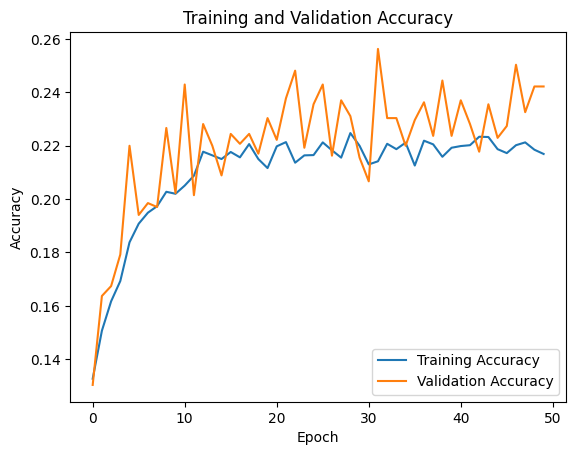

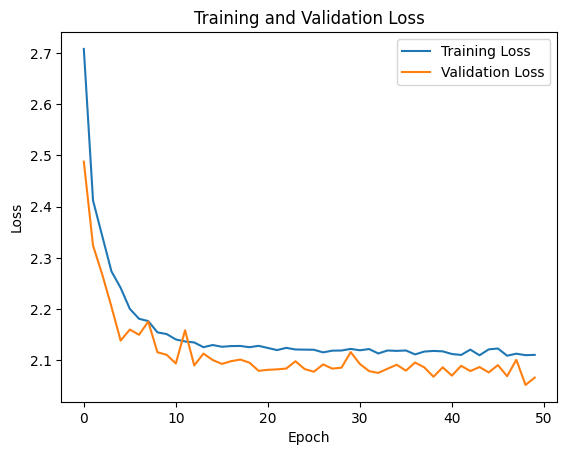

Epoch 1/10
2954/2954 [==============================] - 40s 12ms/step - loss: 1.9681 - accuracy: 0.2901 - val_loss: 2.1436 - val_accuracy: 0.2698
Epoch 2/10
2954/2954 [==============================] - 32s 11ms/step - loss: 1.8592 - accuracy: 0.3211 - val_loss: 2.2162 - val_accuracy: 0.2173
Epoch 3/10
2954/2954 [==============================] - 33s 11ms/step - loss: 1.8427 - accuracy: 0.3286 - val_loss: 7.7028 - val_accuracy: 0.2018
Epoch 4/10
2954/2954 [==============================] - 32s 11ms/step - loss: 1.8311 - accuracy: 0.3327 - val_loss: 2.7248 - val_accuracy: 0.2139
Epoch 5/10
2954/2954 [==============================] - 31s 10ms/step - loss: 1.8206 - accuracy: 0.3365 - val_loss: 2.4853 - val_accuracy: 0.2121
Epoch 6/10
2954/2954 [==============================] - 30s 10ms/step - loss: 1.8113 - accuracy: 0.3409 - val_loss: 2.1001 - val_accuracy: 0.2682
Epoch 7/10
2954/2954 [==============================] - 31s 10ms/step - loss: 1.8106 - accuracy: 0.3423 - val_loss: 6.7003 -

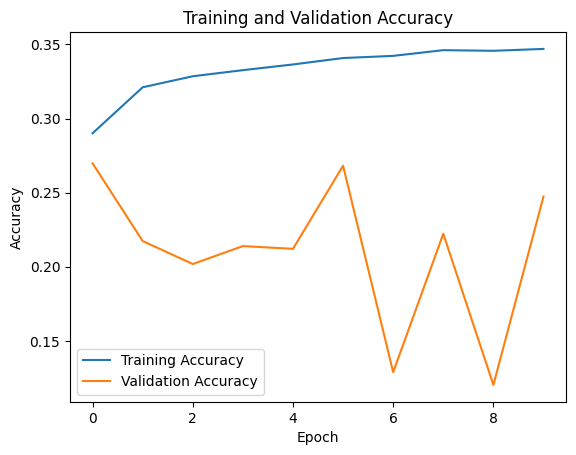

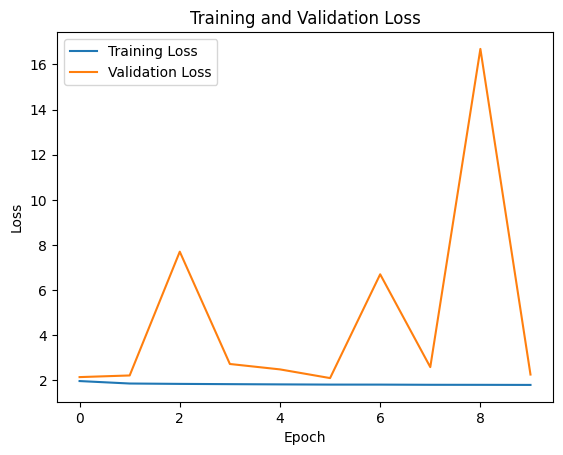

1688/1688 [==============================] - 11s 7ms/step


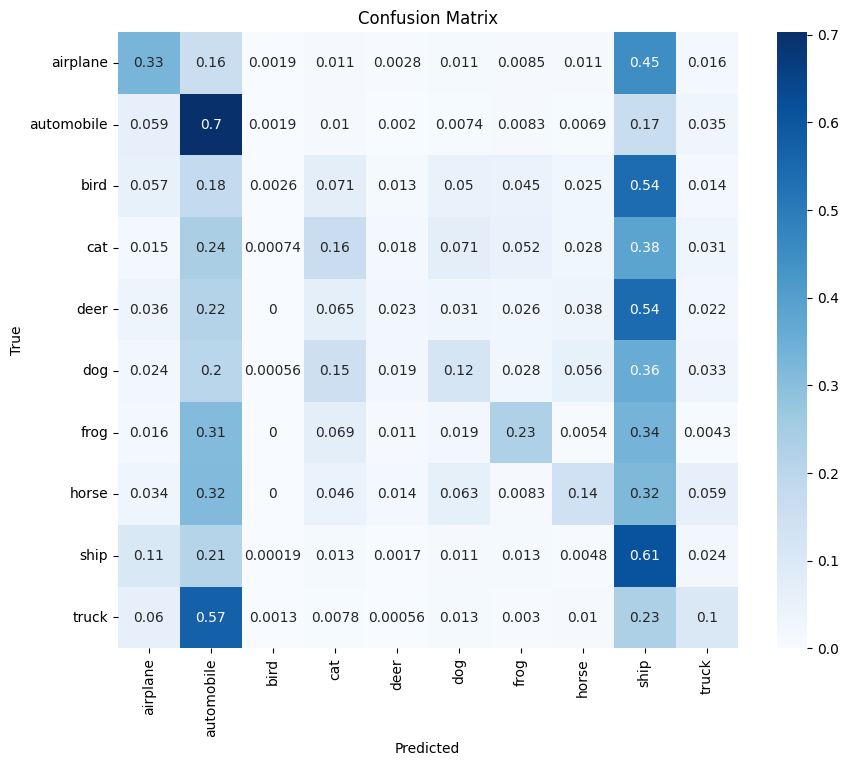

In [16]:
print(results)
print(best)
print(histories)

with open("results-mobilenet","wb") as my_csv:
    pickle.dump(results,my_csv)

with open("best-mobilenet","wb") as my_csv:
    pickle.dump(best,my_csv)
with open("histories-mobilenet","wb") as my_csv:
    pickle.dump(histories,my_csv)




# Plot training and validation accuracy
plt.plot(histories[len(histories)-1].history['accuracy'], label='Training Accuracy')
plt.plot(histories[len(histories)-1].history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.savefig("MobileNet-50epochs-TrainingandValidationAccuracy.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot training and validation loss
plt.plot(histories[len(histories)-1].history['loss'], label='Training Loss')
plt.plot(histories[len(histories)-1].history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.savefig("MobileNet-50epochs-TrainingandValidationLoss.pdf", format="pdf", bbox_inches="tight")
plt.show()

model = createModel(modelType=ModelType.MobileNet,regularizer={"type":RegularizationType.NoRegularization,"value":0},optimizer=getOptimizer(type=OptimizerType.Adam,learningRate=0.01), loss='categorical_crossentropy', metrics=['accuracy'],seed=123, augmentation=AugmentationTechnique.NoAugmentation)
# train the model
history = model.fit(batch_size=64,epochs=10, train_images=train_images,train_labels=train_labels,valid_images=valid_images,valid_labels=valid_labels)



with open("mobilenet-history","wb") as my_csv:
    pickle.dump(history,my_csv)



# get accuracy
y_pred = model.predict(test_images)
# Convert probabilities to class labels
predicted_classes = np.argmax(y_pred, axis=1)

# Get true class labels
true_classes = np.argmax(test_labels, axis=1)
accuracy = getAccuracy(predicted_classes,true_classes)


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig("MobileNet-TrainingandValidationAccuracy.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("MobileNet-TrainingandValidationLoss.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Predict probabilities for test data
predictions = model.predict(test_images)
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = np.argmax(test_labels, axis=1)

# Get class labels
class_labels = sorted(os.listdir(test_data_dir))
class_labels = [class_name for class_name in class_labels if class_name != '.DS_Store']

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("MobileNet-ConfusionMatrix.pdf", format="pdf", bbox_inches="tight")
plt.show()




In [17]:
indicesAugmentation = [0,17]
indicesRegularization = [18,35]
indicesBatchSize = [36,41]
indicesLearningRates = [42,47]
columns = ['Accuracy','Augmentation','Regularizer','Batch Size','Learning Rate','Number of Epochs','Seed']


In [18]:
def extractAugmentationName(augmentation):
    match augmentation:
        case AugmentationTechnique.NoAugmentation:
            return 'No Augmentation';
        case AugmentationTechnique.Rotation:
            return 'Rotation'
        case AugmentationTechnique.Flipping:
            return 'Flipping'
        case AugmentationTechnique.Brightness:
            return 'Brightness'
        case AugmentationTechnique.Contrast:
            return 'Contrast'
        case AugmentationTechnique.RandomErasing:
            return 'Random Erasing'
        case AugmentationTechnique.Zoom:
            return 'Zoom'
def extractRegularizationType(regularization):
    match regularization['type']:
        case RegularizationType.Dropout:
            return "Dropout ("+str(regularization['value'])+")"
        case RegularizationType.NoRegularization:
            return "None"
        case RegularizationType.L2:
            return "L2 ("+str(regularization['value'])+")"


In [19]:
def extractResults(results,best, modelName):
    # bestDF = pd.DataFrame(best,columns = ['Accuracy','Batch Size','Learning Rate','Number of Epochs','Augmentation','Regularizer'])
    augmentationResults = pd.DataFrame(results[indicesAugmentation[0]:indicesAugmentation[1]+1], columns=columns)
    regularizationResults = pd.DataFrame(results[indicesRegularization[0]:indicesRegularization[1]+1], columns=columns)
    batchSizesResults = pd.DataFrame(results[indicesBatchSize[0]:indicesBatchSize[1]+1], columns=columns)
    learningRatesResults = pd.DataFrame(results[indicesLearningRates[0]:indicesLearningRates[1]+1], columns=columns)

    result1 = augmentationResults.loc[augmentationResults['Regularizer'] == regularizers[0]]
    result2 = result1.loc[result1['Augmentation'] == best[4]]
    regularizationResults = pd.concat([regularizationResults, result2], ignore_index=True, sort=False)


    result1 = regularizationResults.loc[regularizationResults['Batch Size'] == batchSizes[0]]
    result2 = result1.loc[result1['Regularizer'] == best[5]]
    batchSizesResults = pd.concat([batchSizesResults, result2], ignore_index=True, sort=False)

    result1 = batchSizesResults.loc[batchSizesResults['Learning Rate'] == learningRates[0]]
    result2 = result1.loc[result1['Batch Size'] == best[1]]
    learningRatesResults = pd.concat([learningRatesResults, result2], ignore_index=True, sort=False)


    augmentationResults['Augmentation'] = augmentationResults['Augmentation'].apply(extractAugmentationName)
    regularizationResults['Regularizer'] = regularizationResults['Regularizer'].apply(extractRegularizationType)

    plt.figure(figsize=(8,8))
    plt.title("Accuracy vs Augmentation ("+modelName+")")
    sns.boxplot(data=augmentationResults,x='Augmentation',y='Accuracy')
    plt.savefig("AccuracyvsAugmentation"+f"{modelName}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.figure(figsize=(9,9))
    plt.title("Accuracy vs Regularizer ("+modelName+")")
    sns.boxplot(data=regularizationResults,x='Regularizer',y='Accuracy')
    plt.savefig("AccuracyvsRegularizer"+f"{modelName}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    plt.title("Accuracy vs Batch Size ("+modelName+")")
    sns.boxplot(data=batchSizesResults,x='Batch Size',y='Accuracy')
    plt.savefig("AccuracyvsBatchSize"+f"{modelName}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    plt.title("Accuracy vs Learning Rate ("+modelName+")")
    sns.boxplot(data=learningRatesResults,x='Learning Rate',y='Accuracy')
    plt.savefig("AccuracyvsLearningRate"+f"{modelName}.pdf", format="pdf", bbox_inches="tight")
    plt.show()




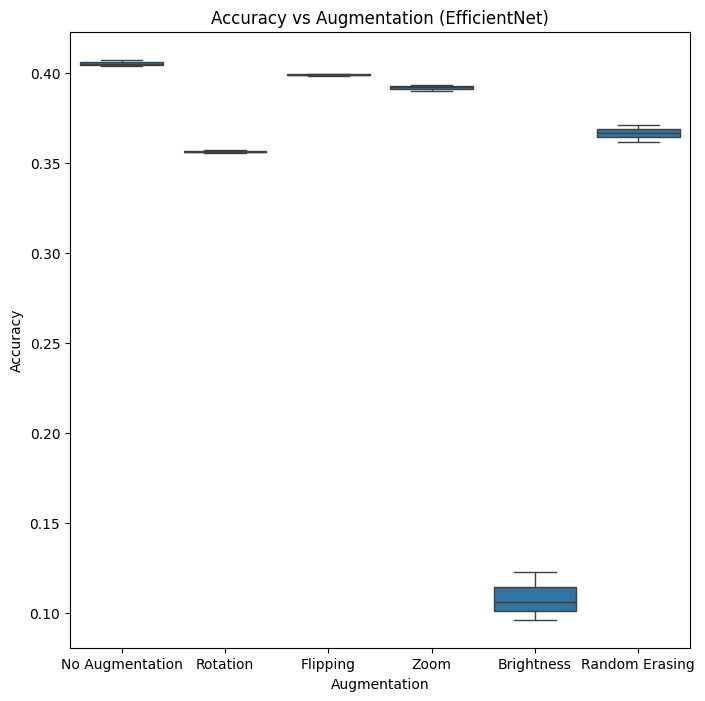

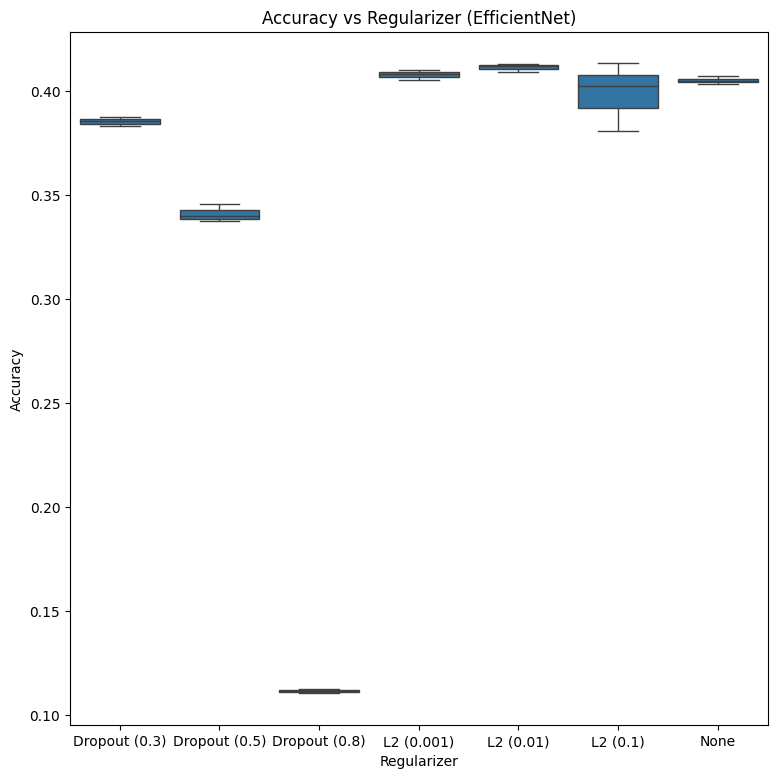

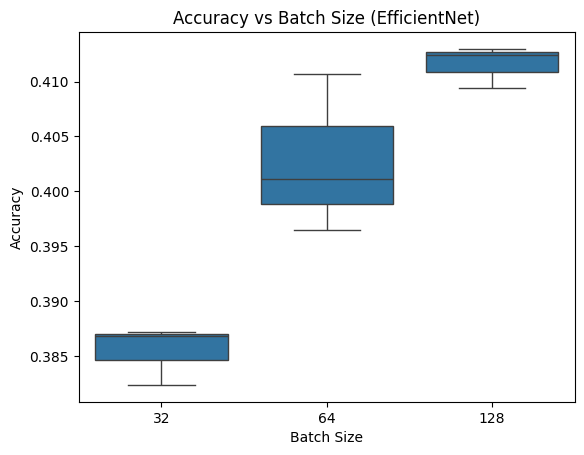

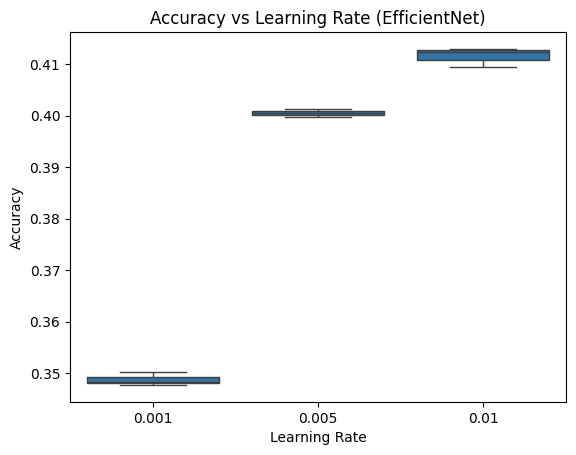

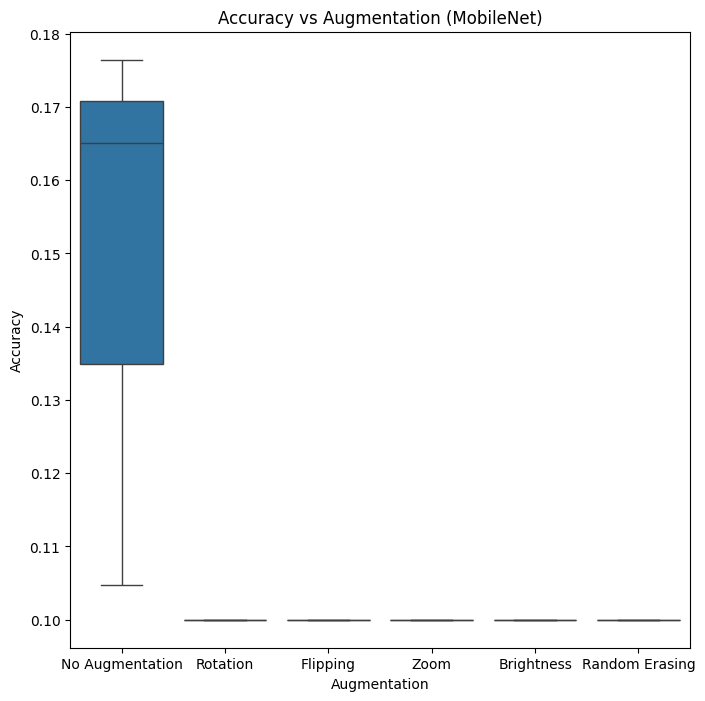

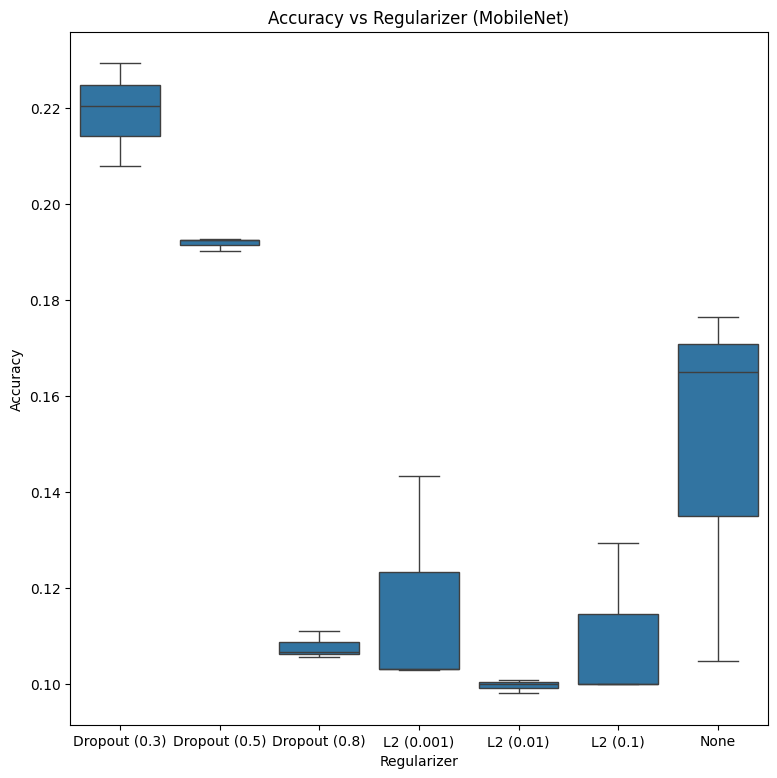

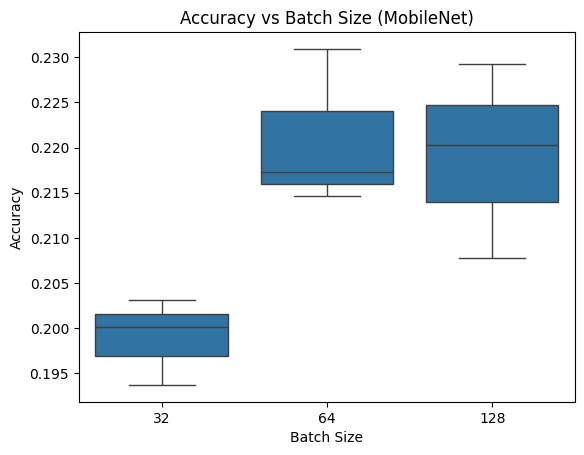

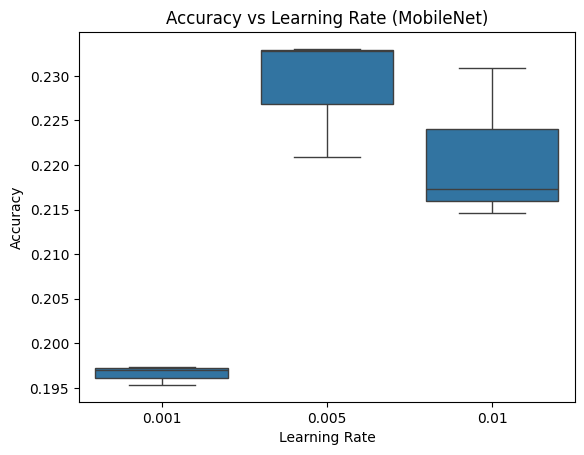

In [21]:
with open(r"results", "rb") as input_file:
    results = pickle.load(input_file)

with open(r"best", "rb") as input_file:
    best = pickle.load(input_file)

extractResults(results=results,best=best,modelName='EfficientNet')

with open(r"results-mobilenet", "rb") as input_file:
    results = pickle.load(input_file)

with open(r"best-mobilenet", "rb") as input_file:
    best = pickle.load(input_file)

extractResults(results=results,best=best,modelName='MobileNet')

